# Analyze NFL Stats

Adolfo F. Calderon \
DS 315: Machine Learning \
11/26/2022

## Setup and inspection

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Load the dataset

After loading all the necessary libraries, the next step is to load the dataset. \
Data Source https://www.pro-football-reference.com

The dataset `season_2021.csv` is saved as `nfl`.

<details>
    <summary style="display:list-item;"><b>Overview of the variables in the dataset.</b></summary>

* `symbol`: team name abbreviation
* `team_name`: team name
* `result`: whether this team won (`W`), lost (`L`), or tied (`T`) for this game
* `1stD_offense`: First down conversions by the team's offense
* `TotYd_offense`: Total yards gained by the team's offense
* `PassY_offense`: Total passing yards gained by the team's offense
* `RushY_offense`: Total rushing yards gained by the team's offense
* `TO_offense`: Turnovers committed by the team's offense
* `1stD_defense`: First down conversions allowed by the team's defense
* `TotYd_defense`: Total yards allowed by the team's defense
* `PassY_defense`: Total passing yards allowed by the team's defense
* `RushY_defense`: Total rushing yards allowed by the team's defense
* `TO_defense`: Turnovers in favor of the defensive team

</details>

In [2]:
# load dataset
nfl = pd.read_csv('season_2021.csv')

# inspect first few rows
nfl.head()

,team_name,week,day,date,result,opponent,tm_score,opp_score,1stD_offense,TotYd_offense,PassY_offense,RushY_offense,TO_offense,1stD_defense,TotYd_defense,PassY_defense,RushY_defense,TO_defense
0,Arizona Cardinals,1,Sun,September 12,W,Tennessee Titans,38,13,22,416,280,136,1,17,248,162,86,3
1,Arizona Cardinals,2,Sun,September 19,W,Minnesota Vikings,34,33,21,474,371,103,2,22,419,242,177,0
2,Arizona Cardinals,3,Sun,September 26,W,Jacksonville Jaguars,31,19,23,407,316,91,1,20,361,202,159,4
3,Arizona Cardinals,4,Sun,October 3,W,Los Angeles Rams,37,20,27,465,249,216,0,24,401,280,121,2
4,Arizona Cardinals,5,Sun,October 10,W,San Francisco 49ers,17,10,20,304,210,94,1,19,338,186,152,1


### 2. Summarize outcomes

Next, we examine our outcome variable to find out how wins and losses are recorded by checking the counts of each value of the `result` variable.

In [3]:
# check result value counts
nfl.result.value_counts()

L    284
W    284
T      2
Name: result, dtype: int64

### 3. Encode the result labels

There are two problems with the `result` variable:
* The `T` group is very small, which can lead to issues with our model's performance.
* Our regression algorithm requires numeric values as the outcome, but by default it's coded with letters.

We can solve both of these issues in one step, we'll group the tie with the losses and convert to 1 for wins and 0 for ties and losses. 

In [4]:
# nested dictionary to encode alphanumeric values to numeric values
# specify 'result' column
result_encoder = {'result': {'W': 1, 'T': 0, 'L': 0}}

# encode result column using encoder
nfl.replace(result_encoder, inplace=True)
# check result value counts 
print(nfl.result.value_counts())

0    286
1    284
Name: result, dtype: int64


### 4. Visualize the stats

Next we take a look at the features, utilizing boxplots to vizualize their effect on the reponse.

PassY_offense


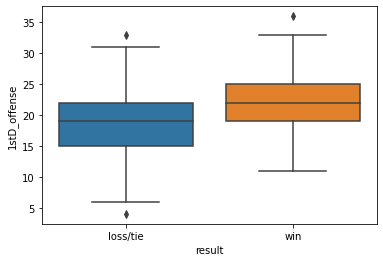

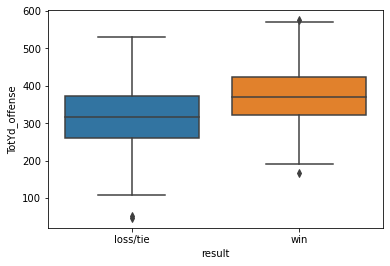

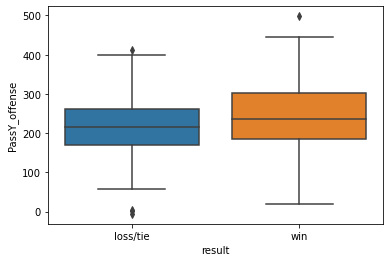

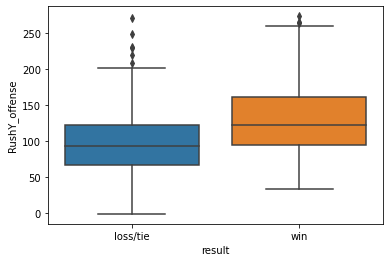

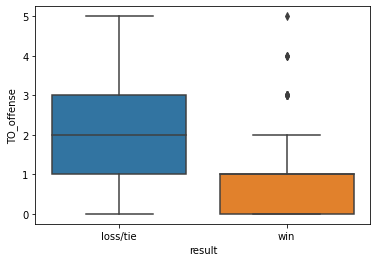

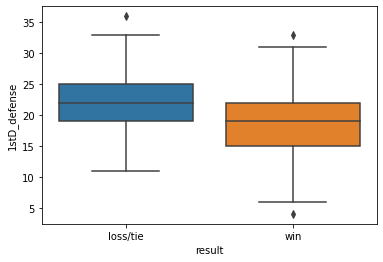

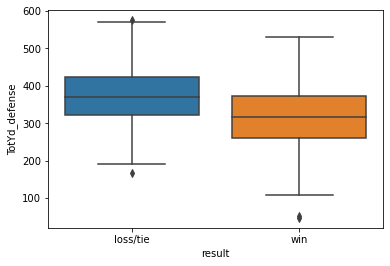

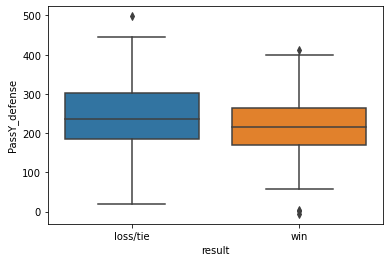

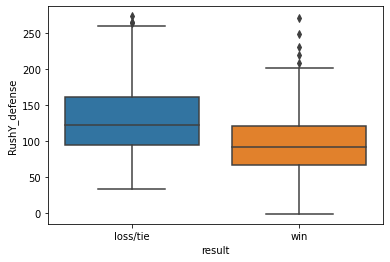

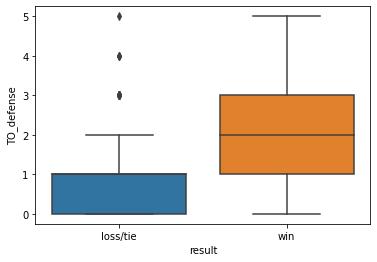

Index(['1stD_offense', 'TotYd_offense', 'PassY_offense', 'RushY_offense',
       'TO_offense', '1stD_defense', 'TotYd_defense', 'PassY_defense',
       'RushY_defense', 'TO_defense'],
      dtype='object')


In [5]:
# change stat to view plot
stat = "PassY_offense"
print(stat)

features = [i for i in nfl.columns[8:]]

# box plot of stat
# stat_plot = sns.boxplot(x='result', y=stat, data=nfl)
# box plot of all featrues
for stat in features:
    stat_plot = sns.boxplot(x='result', y=stat, data=nfl)
    stat_plot.set_xticklabels(['loss/tie','win'])
    plt.show()

# plot labels
# stat_plot.set_xticklabels(['loss/tie','win'])
plt.show()
# feature names
print(nfl.columns[8:])

The trend we find when looking through all the stats is that winning teams have higher offensive stats on average (indicating more opportunities to score points) and lower defensive stats on average (indicating fewer opportunities for the opponent to score points). This is good news for our machine learning algorithm, as it should be straightforward for the algorithm to learn this pattern among the data.

## Data Preparation

### 5. Standardize features

Before creating a model, the data needs to be standardized so that a feature like Total Yards Gained doesn't overshadow Turnovers, which can be a crucial feature in determining winning games.

The function `scaler.fit()` fits `features` to the the scaling function. Then `scaler.transform()` standardizes the game stats. The output is saved as `X` for easy refrence.

In [6]:
# select feature variables to be scaled
predictors = nfl.iloc[:,8:]
print(predictors)
scaler = StandardScaler()

# fit the transformer to the features
scaler.fit(predictors)


# transform and save as X
X = scaler.transform(predictors)

     1stD_offense  TotYd_offense  PassY_offense  RushY_offense  TO_offense  \
0              22            416            280            136           1   
1              21            474            371            103           2   
2              23            407            316             91           1   
3              27            465            249            216           0   
4              20            304            210             94           1   
..            ...            ...            ...            ...         ...   
565            14            224            124            100           4   
566            14            237            174             63           0   
567            14            257            172             85           2   
568            24            312            218             94           1   
569            16            325             99            226           0   

     1stD_defense  TotYd_defense  PassY_defense  RushY_defense 

### 6. Save game outcomes

Also separating the game outcome variable for easier reference. The game outcomes will be set to `y`.

In [7]:
# save result variable as y
y = nfl['result']

### 7. Split into training and testing data

Need to randomly split the data into two groups:
* **training data:** data to train the model to recognize winning games from patterns in the game stats.
* **testing data:** data to check model's accuracy.

The `train_test_split()` function will split up the features and result labels into training data and testing data, with `test_size` corresponding to the proportion of data reserved for testing. `test_size` is set to 0.5 and `random_state` to 42.

In [8]:
# create training data/ outcomes, test data/outcomes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Analysis

### 8. Run the model

In this step, we'll train the model to use the patterns of the offensive and defensive stats to predict the probability of a winning game.

In [9]:
# create the classifier
log_model = LogisticRegression()
# fit classifier to the training data
log_model.fit(X_train, y_train)

LogisticRegression()

### 9. Check model accuracy

With the classifier fitted (trained) to the training data, we can use the trained classifier to make predictions on the test data.

Now we can check the percentage of outcomes that our model predicted correctly. The `accuracy_score()` function imported from the `sklearn` library compares the predicted test values `y_pred` to the true values `y_test`.

In [10]:
# predict with the classifier using the .predict() function
print(X_test[0])
y_pred = log_model.predict(X_test)

# view the model accuracy with the accuracy_score() function
accuracy_score(y_pred, y_test)

[-1.04969195 -1.59960858 -1.23689322 -0.80285837  0.59128788  0.33577642
  0.57942158  0.74017193 -0.17215071 -0.24919614]


0.8280701754385965

We can see from the model performance that we can predict wins and losses with good accuracy. The model correctly predicted the game outcome for 82.8% of the games in the test set. The next steps might be to try to tune the model to optimize predictive performance.

### 10. Optimize by tuning hyperparameters

We can improve model performance by closely studying how different parameters affect performance. In this next step I'll consider two "hyperparameters" for the `LogisticRegression` classifier: `penalty` and `C`.

* `penalty` imposes a regularization penalty on the model for having too many variables. Our options generally are `l1` or "Lasso Regression" and `l2` "Ridge Regression" regularization.
* `C` is the magnitude of the regularization

The following code runs a logistic regression on the data and gets an accuracy score for each combination of `penalty` and `C`.

In [11]:
# create the list of both penalties
penalties = ['l1', 'l2']
# create a list of magnitudes
C = [0.01, 0.1, 1.0, 10.0, 1000.0]

for penalty in penalties:
    for c in C:

        # instantiate the classifier
        # liblinear is used as a "solver"
        # LogisticRegression() is weird it doesn't support l1 regression
        # using liblinear fixes it
        lrc_tuned = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

        # fit the classifier to the training data
        lrc_tuned.fit(X_train, y_train)
        
        # predict with the classifier using the .predict() function
        y_pred = lrc_tuned.predict(X_test)

        # view the model accuracy with the accuracy_score() function
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_rd = round(accuracy*100,1)
        
        # print accuracy for each combination of penalty and C
        print(f'Accuracy: {accuracy_rd}% | penalty = {penalty}, C = {c}')

Accuracy: 52.3% | penalty = l1, C = 0.01
Accuracy: 84.6% | penalty = l1, C = 0.1
Accuracy: 83.2% | penalty = l1, C = 1.0
Accuracy: 82.5% | penalty = l1, C = 10.0
Accuracy: 82.5% | penalty = l1, C = 1000.0
Accuracy: 80.4% | penalty = l2, C = 0.01
Accuracy: 83.5% | penalty = l2, C = 0.1
Accuracy: 82.8% | penalty = l2, C = 1.0
Accuracy: 82.5% | penalty = l2, C = 10.0
Accuracy: 82.5% | penalty = l2, C = 1000.0


A lot of these accuracy scores are very similar (or identical) to our original accuracy score. We end up gaining a small benefit by changing the hyperparameters to `penalty = l1` and `C = 0.1`. This brings us from 82.8% to 84.6% accuracy.

### 11. Optimize by changing test size

In the cell above, we see that sweeping our parameters did not yield much improvement in prediction accuracy. Changing the test size of the train-test split could yield better results. A list of test sizes between 0 and 1 has been coded for you. Similar to the last task, at each test size the code performs a train-test split, fits the model, and computes an accuracy score.

Run the code to see how test size affects accuracy. If you'd like, try changing the list of test sizes to get better accuracy.

In [12]:
# optimal penalty and C
penalty = 'l1'
C = 0.1

# create a list of test_sizes
test_sizes = [val/100 for val in range(20,36)]

for test_size in test_sizes:

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # instantiate the classifier
    lrc_tts = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

    # fit the classifier to the training data
    lrc_tts.fit(X_train, y_train)

    # predict with the classifier using the .predict() function
    y_pred = lrc_tts.predict(X_test)

    # view the model accuracy with the accuracy_score() function
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_rd = round(accuracy*100,1)
    
    # print accuracy for each combination of penalty and test size
    print(f'Accuracy: {accuracy_rd}% | test size = {test_size}')

Accuracy: 87.7% | test size = 0.2
Accuracy: 87.5% | test size = 0.21
Accuracy: 87.3% | test size = 0.22
Accuracy: 87.9% | test size = 0.23
Accuracy: 88.3% | test size = 0.24
Accuracy: 88.8% | test size = 0.25
Accuracy: 87.9% | test size = 0.26
Accuracy: 88.3% | test size = 0.27
Accuracy: 88.1% | test size = 0.28
Accuracy: 88.6% | test size = 0.29
Accuracy: 87.1% | test size = 0.3
Accuracy: 87.6% | test size = 0.31
Accuracy: 86.9% | test size = 0.32
Accuracy: 87.3% | test size = 0.33
Accuracy: 86.1% | test size = 0.34
Accuracy: 86.0% | test size = 0.35


As we can see from the output, we were able to improve accuracy slightly with a test size of `0.25`. In this step, we improved from 84.6% correct predictions to 88.8% correct predictions.

### 12. Save the optimized model

Now that we know which parameters optimize our model, we can run and save the final model with our choices for `test_size`, `penalty`, and `C`. We continue using the same `random_state` of 42. 

In [13]:
# set the test size and hyperparameters
test_size = 0.25
penalty = "l1"
C = 0.1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

# instantiate the classifier
optimized_model = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

# fit the classifier to the training data
optimized_model.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

### 13. Examine feature importance

Arguably the most important part, finding out which features determine a winning team. To do this we can the plot the coefficients (to vizualize how much they contribute to the outcome) 
We'll print and plot these scores to see which stat has the highest score.

[ 0.05443596  0.59570588  0.          0.12254822 -0.756645   -0.198302
 -0.59921219  0.         -0.2078041   0.76348845]


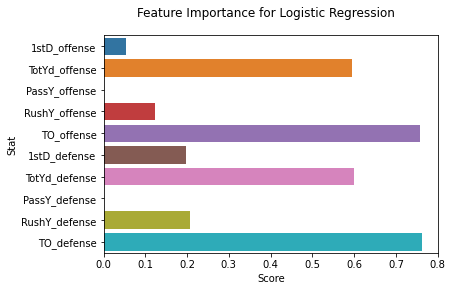

Predictor: 1stD_offense, Score: 0.05
Predictor: TotYd_offense, Score: 0.6
Predictor: PassY_offense, Score: 0.0
Predictor: RushY_offense, Score: 0.12
Predictor: TO_offense, Score: 0.76
Predictor: 1stD_defense, Score: 0.2
Predictor: TotYd_defense, Score: 0.6
Predictor: PassY_defense, Score: 0.0
Predictor: RushY_defense, Score: 0.21
Predictor: TO_defense, Score: 0.76


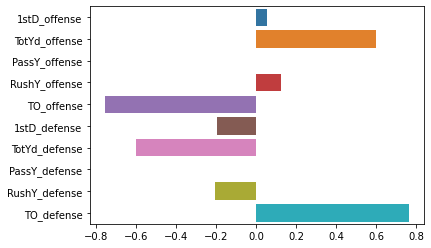

In [14]:
# get importance for each predictor
# you can also do it without the absolute value to see
# which ones impact the outcome negatively, but it looks kinda weird
# not very easy to see the impact


importance = abs(optimized_model.coef_[0])


# visualize feature importance
sns.barplot(x=importance, y=predictors.columns)
plt.suptitle('Feature Importance for Logistic Regression')
plt.xlabel('Score')
plt.ylabel('Stat')
plt.show()


importance2 = optimized_model.coef_[0]


sns.barplot(x=importance2, y=predictors.columns)

# # add labels and titles
# plt.suptitle('Feature Importance for Logistic Regression')
# plt.xlabel('Score')
# plt.ylabel('Stat')
# plt.show()


# summarize feature importance
for i,v in enumerate(importance.round(2)):
    print(f'Predictor: {predictors.columns[i]}, Score: {v}')

## Conclusion/ Next Steps

- I created a Machine Learning Model based on NFL team stats from 2021. With some hyperparameter tuning, the model was optimized to an accuracy of 88.8%. This means the model can classify NFL games with the 2021 teams with over 85% accuracy. The next steps for this project would be to create a predict function that takes two teams as input; the function would then average the team's stats for the season, and pit them against one another as in the original model to generate a prediction for an upcoming game.